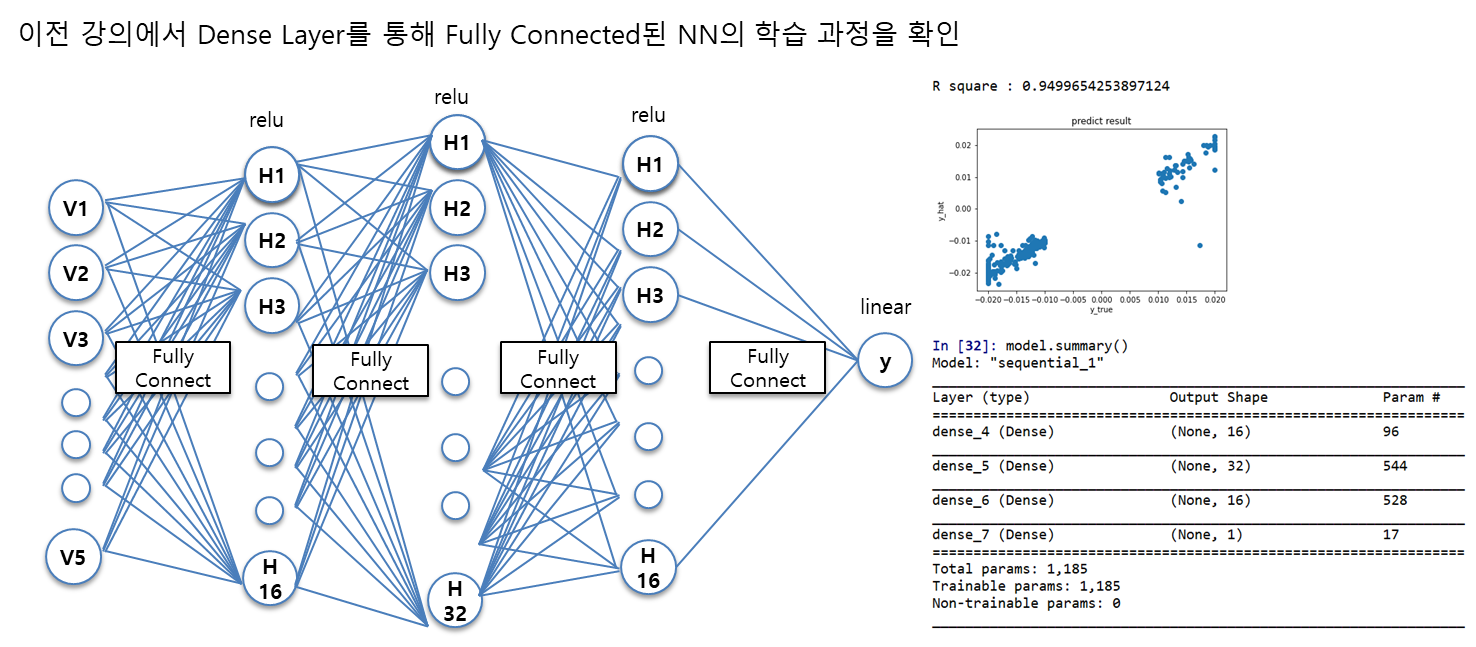

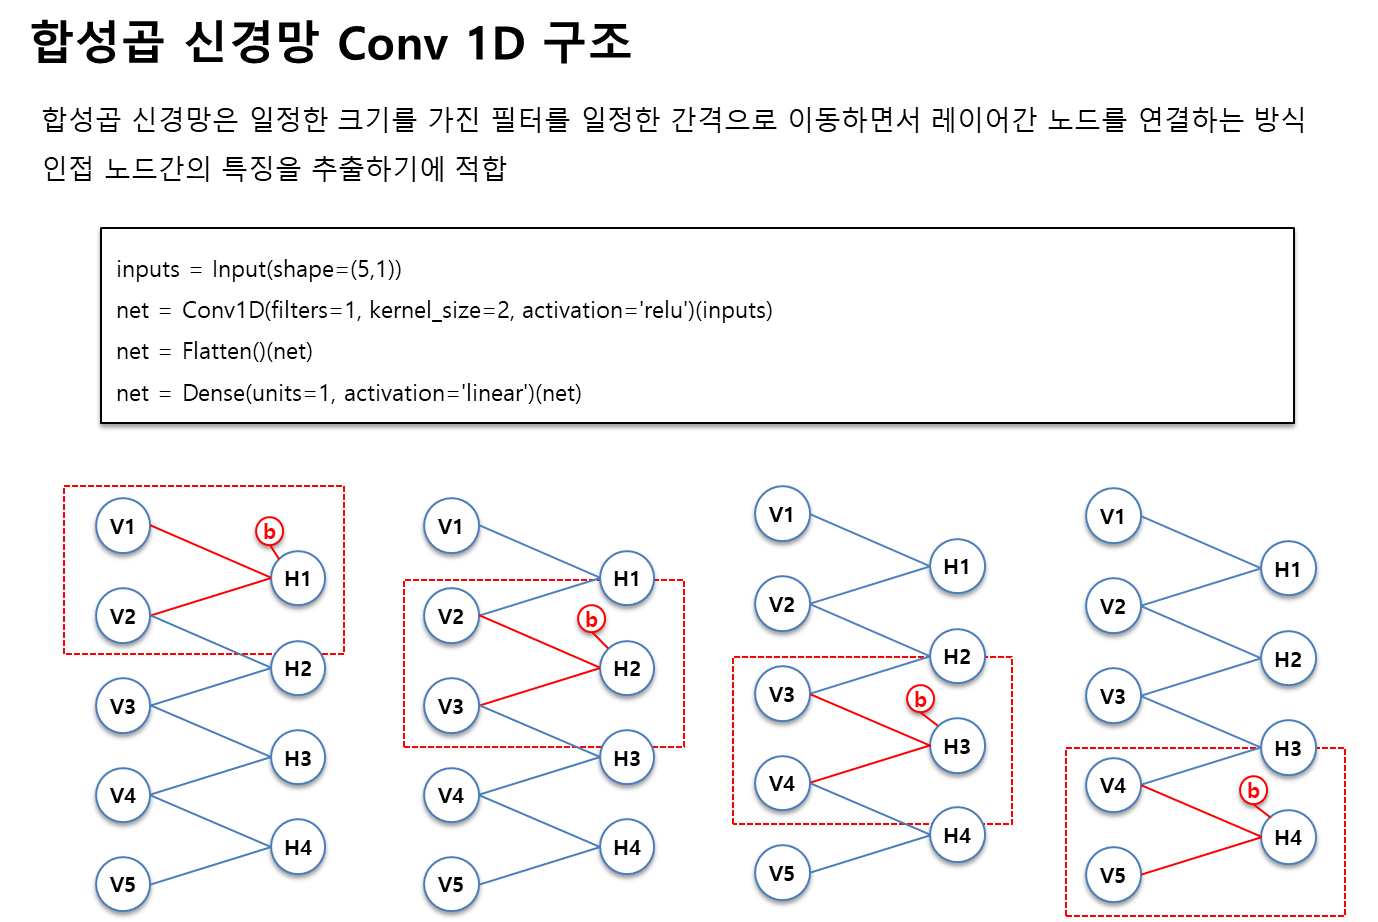

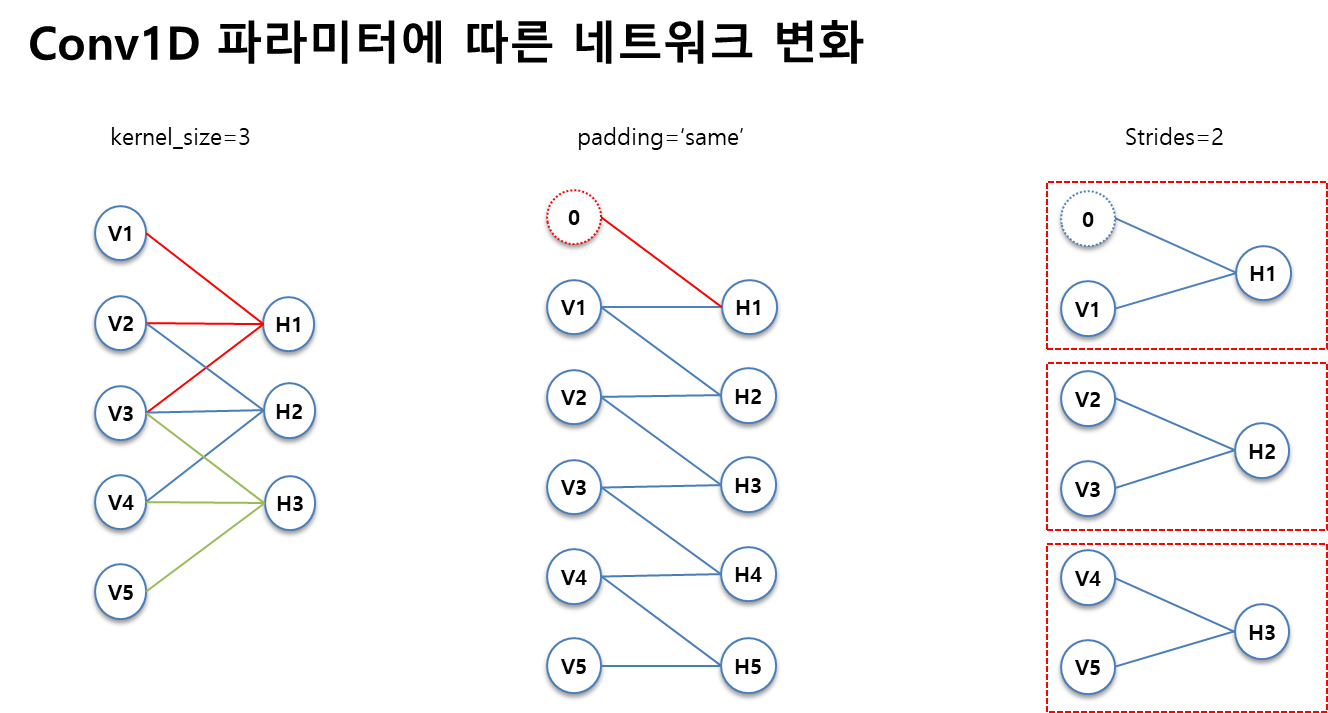

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=670b2a7c70f18" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

In [ ]:
import pandas as pd
import numpy as np
import os

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, concatenate, Add, Conv1D, Flatten

In [ ]:
sdot_data_total = pd.read_csv('data/sdot학습데이터.csv', sep='|', encoding='cp949')
"""전체 Sdot 평균기온과의 온도차 평균이 높으면 1, 낮으면 0으로 종속변수 생성"""
sdot_data_total['종속'] = sdot_data_total['온도차이'].apply(lambda x: 0 if x < 0 else 1)

sdot_data_total.columns.values

In [ ]:

""" 모든 입력변수를 이용한 분석"""
tmp = sdot_data_total

x_column_name = tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])
y_column_name = "온도차이"
x = np.array(tmp[x_column_name].fillna(0).astype('float').values)
y = np.array(tmp['종속'].values)
y = y.reshape(y.shape[0], 1)

print(x.shape)
print(y.shape)

In [ ]:
x = x[:, :10]

In [ ]:
def visualize_nn(model):
    dot = Digraph()
    layers = model.layers

    previous_layer_nodes = []

    for i, layer in enumerate(layers):
        if isinstance(layer, Dense):
            # Dense 레이어 처리
            input_nodes = [f"Layer {i+1} Input {j+1}" for j in range(layer.input.shape[-1])]
            output_nodes = [f"Layer {i+1} Output {j+1}" for j in range(layer.output.shape[-1])]

            # 노드 추가 (입력 및 출력)
            for node in input_nodes:
                dot.node(node, shape='circle')
            for node in output_nodes:
                dot.node(node, shape='circle')

            # 이전 레이어와 연결
            if previous_layer_nodes:
                for prev_node in previous_layer_nodes:
                    for output_node in input_nodes:
                        dot.edge(prev_node, output_node)

            # 입력에서 출력으로 연결 (모든 입력 -> 모든 출력)
            for input_node in input_nodes:
                for output_node in output_nodes:
                    dot.edge(input_node, output_node)

            previous_layer_nodes = output_nodes

        elif isinstance(layer, Conv1D):
            # Conv1D 레이어 처리
            input_nodes = [f"Layer {i+1} Conv1D Input {j+1}" for j in range(layer.input.shape[1])]
            output_nodes = [f"Layer {i+1} Conv1D Output {j+1}" for j in range(layer.output.shape[1])]

            # 노드 추가 (입력 및 출력)
            for node in input_nodes:
                dot.node(node, shape='circle')
            for node in output_nodes:
                dot.node(node, shape='circle')

            # 이전 레이어와 연결
            if previous_layer_nodes:
                for prev_node in previous_layer_nodes:
                    for output_node in input_nodes:
                        dot.edge(prev_node, output_node)

            # Conv1D 레이어의 연결 (일부분 연결, 필터 크기 기반)
            filter_size = layer.kernel_size[0]
            for idx, input_node in enumerate(input_nodes):
                for j in range(filter_size):
                    if idx + j < len(output_nodes):
                        dot.edge(input_node, output_nodes[idx+j])

            previous_layer_nodes = output_nodes

    return dot

In [ ]:
inputs = Input(shape=(x.shape[1],1))
net = Dense(units=x.shape[1], activation='relu')(inputs)
net = Dense(units=1, activation='sigmoid')(net)

model = Model(inputs, net)
model.summary()


In [ ]:
# 시각화 실행
nn_visualization = visualize_nn(model)

# Jupyter Notebook에 출력
display(Image(nn_visualization.pipe(format='png')))

In [ ]:
inputs = Input(shape=(x.shape[1],1))
net = Conv1D(filters=1, kernel_size=2, padding='same', activation='relu')(inputs)
net = Flatten()(net)
net = Dense(units=1, activation='linear')(net)

model = Model(inputs, net)
model.summary()


In [ ]:
# 시각화 실행
nn_visualization = visualize_nn(model)

# Jupyter Notebook에 출력
display(Image(nn_visualization.pipe(format='png')))

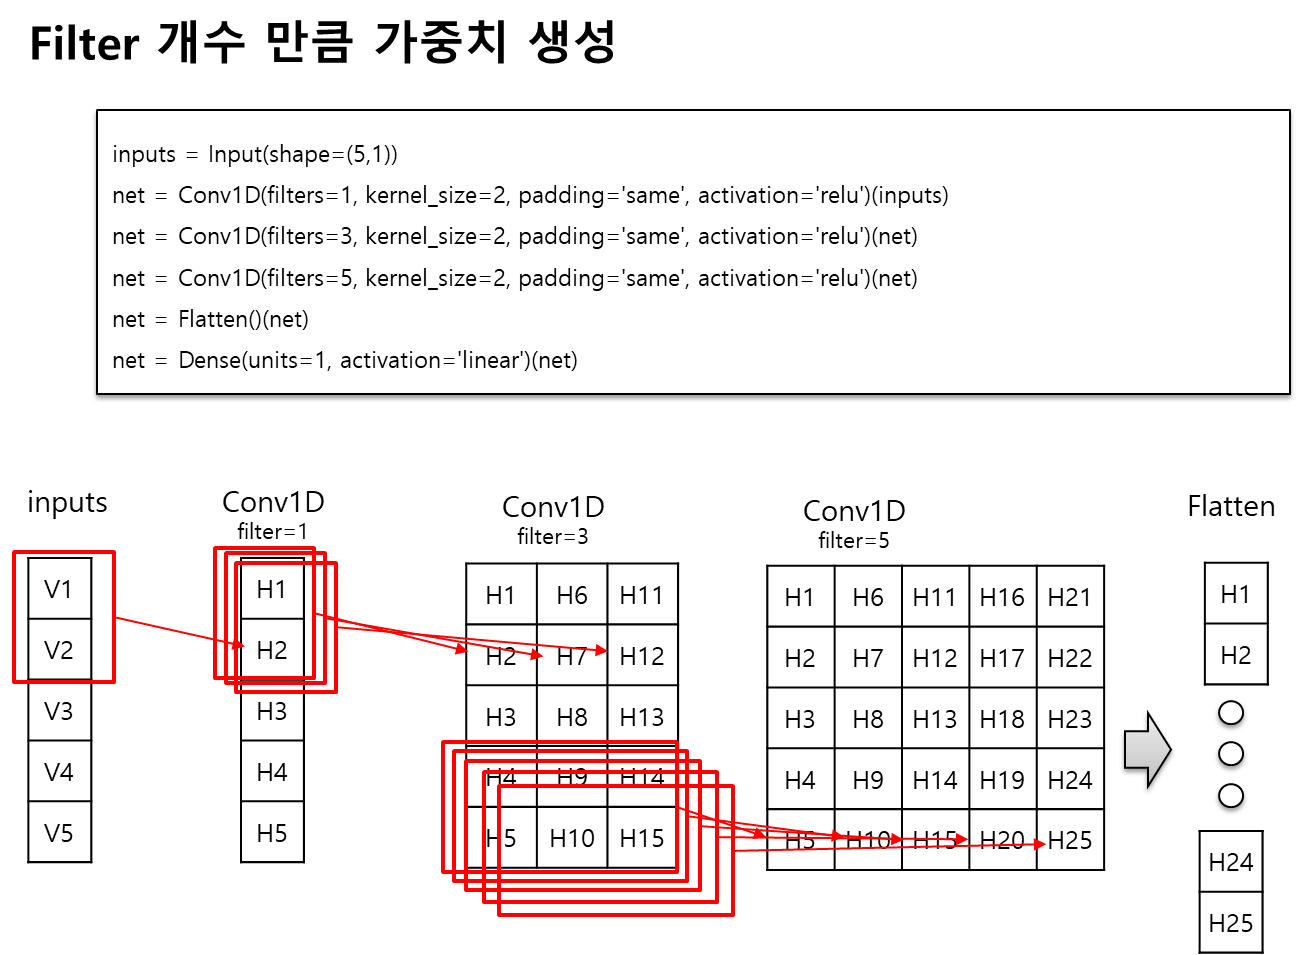

In [ ]:

""" 모든 입력변수를 이용한 분석"""
tmp = sdot_data_total

x_column_name = tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])
y_column_name = "온도차이"
x = np.array(tmp[x_column_name].fillna(0).astype('float').values)
y = np.array(tmp['종속'].values)
y = y.reshape(y.shape[0], 1)

print(x.shape)
print(y.shape)

In [ ]:
inputs = Input(shape=(x.shape[1],1))
net = Conv1D(filters=16, kernel_size=2, padding='same', activation='relu')(inputs)
net = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(net)
net = Conv1D(filters=16, kernel_size=2, padding='same', activation='relu')(net)
net = Flatten()(net)
net = Dense(units=1, activation='linear')(net)

model = Model(inputs, net)
model.summary()


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history  = model.fit(x, y, epochs=300)
